In [12]:
import os, sys
import numpy as np
import mappy
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from collections import Counter
from glob import glob

/tmp/ipykernel_2886341/1200790087.py:13: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(fn, sep="\t")#; df.head()


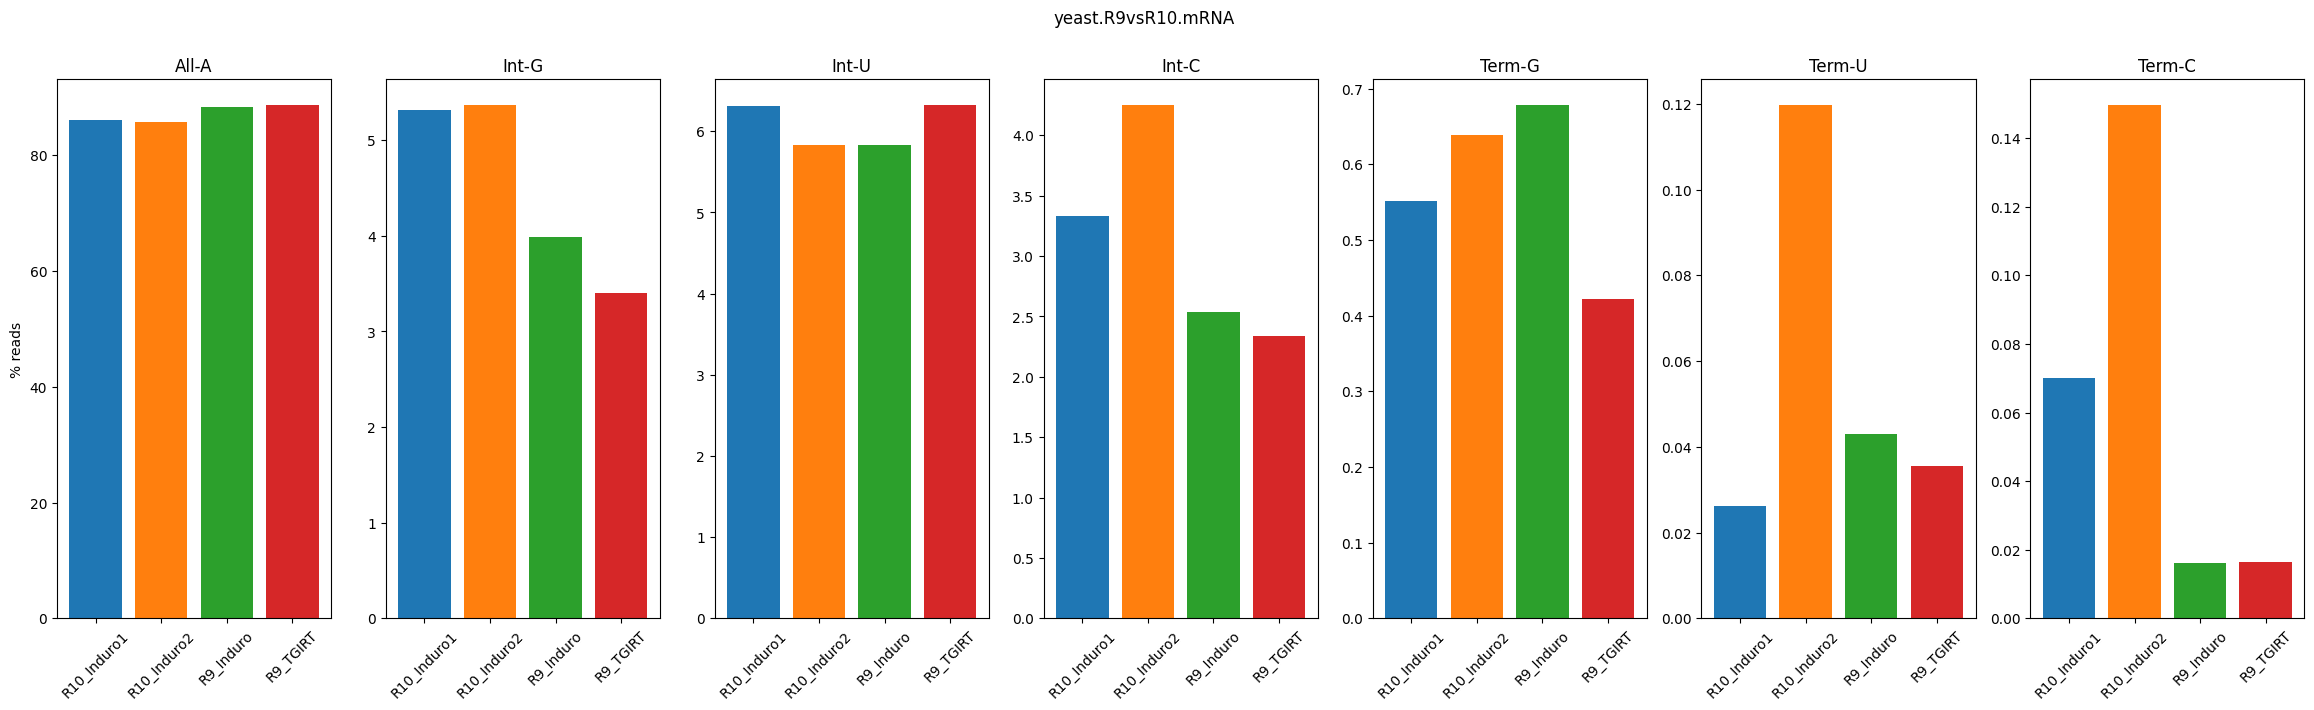

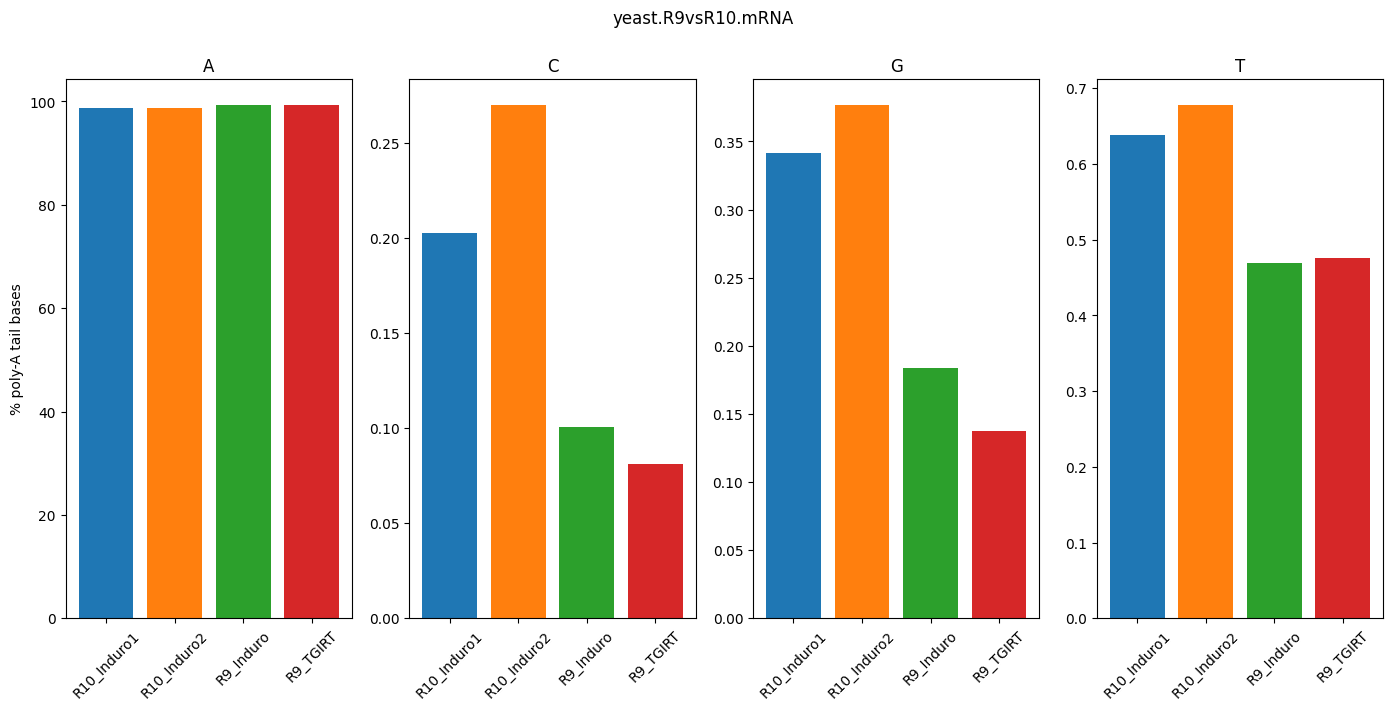

In [36]:
bases = "ACGT"
base2idx = {b: i for i, b in enumerate(bases)}; base2idx
altbase2idx = {'G': 1, 'T': 2, 'C': 3}

def get_data(sample2fname, feature='protein_coding'):
    bc2data = {}
    bc2count = {}
    for bc, fn in sample2fname.items():
        primer_end, trim_ttc = ("CTCTATCTTC", True) if "_R9_" in os.path.basename(fn) else ("CAGAGCAGAG", False)
        if feature=="ext":
            primer_end += "AATTC" # CAATTC
            trim_ttc = True
        df = pd.read_csv(fn, sep="\t")#; df.head()
        mRNA = set([x for x in df.transcript_end.unique() if type(x)==str and x.endswith(feature)]); len(mRNA)
        # Only-A Int-G Int-U Int-C Term-G Term-U Term-C
        counts = np.zeros(7, dtype='int')
        base2count = np.zeros(4, dtype='int')
        tails = df.loc[df.transcript_end.isin(mRNA)&(df.pt_length>=10.), ['before_pt', "pt_seq"]].to_numpy()
        for i, (before, tail) in enumerate(tails, 1):
            #this is needed for older N3PS primer
            if trim_ttc and tail.startswith("TTC"): 
                tail = tail[3:]
                before += "TTC"
            seq = mappy.revcomp(tail)
            #this is needed for older N3PS primer
            if before[:-1]==primer_end[-9:]: seq += mappy.revcomp(before[-1])
            #elif before[-len(primer_end):]!=primer_end: continue
            #'''
            # count Term
            if seq[-1] in altbase2idx:
                counts[3+altbase2idx[seq[-1]]] += 1
            # count Int
            for b in set(seq[:-1]).difference("A"):
                counts[altbase2idx[b]] += 1
            if len(set(seq))==1:
                counts[0] += 1
            # count all bases
            for b, c in Counter(seq).items(): base2count[base2idx[b]] += c
        bc2data[bc] = (base2count, counts)
        bc2count[bc] = i
    return bc2data, bc2count

def plot_data(bc2data, bc2count, fn, xticks=("2", "4", "6"), 
              titles=['All-A', 'Int-G', 'Int-U', 'Int-C', 'Term-G', 'Term-U', 'Term-C']):
    colors = sns.color_palette(n_colors=len(xticks))
    
    data = np.vstack([100.*bc2data[bc][1]/bc2count[bc] for bc in bc2data]); data
    n = len(titles)
    
    fig, axes = plt.subplots(1, n, figsize=(1+4*n, 7))
    for i, ax  in enumerate(axes):
        ax.bar(xticks, data[:, i], color=colors)
        ax.set_title(titles[i])
        ax.tick_params(axis='x', labelrotation=45)
        if not i: ax.set_ylabel("% reads")
    fig.suptitle(fn)
    fig.savefig(f"{fn}.composition.pdf")

    data = np.vstack([100.*bc2data[bc][0]/bc2data[bc][0].sum() for bc in bc2data]); data
    n = len(bases)
    fig, axes = plt.subplots(1, n, figsize=(1+4*n, 7))
    for i, ax  in enumerate(axes):
        ax.bar(xticks, data[:, i], color=colors)
        ax.set_title(bases[i])
        ax.tick_params(axis='x', labelrotation=45)
        if not i: ax.set_ylabel("% poly-A tail bases")
    fig.suptitle(fn)
    fig.savefig(f"{fn}.bases.pdf")

fnpat = "/no_backup/enovoa/users/lpryszcz/cluster/rna_mods/N3Pseq/get_pt.all/N3PS_R*_YeastSequin_*.bam.tsv"
sample2fname = {"_".join(os.path.basename(fn[:-8]).split("_")[1:]).replace("_YeastSequin", ""): fn for fn in sorted(glob(fnpat))}; sample2fname
bc2data, bc2count = get_data(sample2fname, 'protein_coding')
plot_data(bc2data, bc2count, "yeast.R9vsR10.mRNA", sample2fname.keys())
#'''

/tmp/ipykernel_2886341/1426515220.py:13: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(fn, sep="\t")#; df.head()


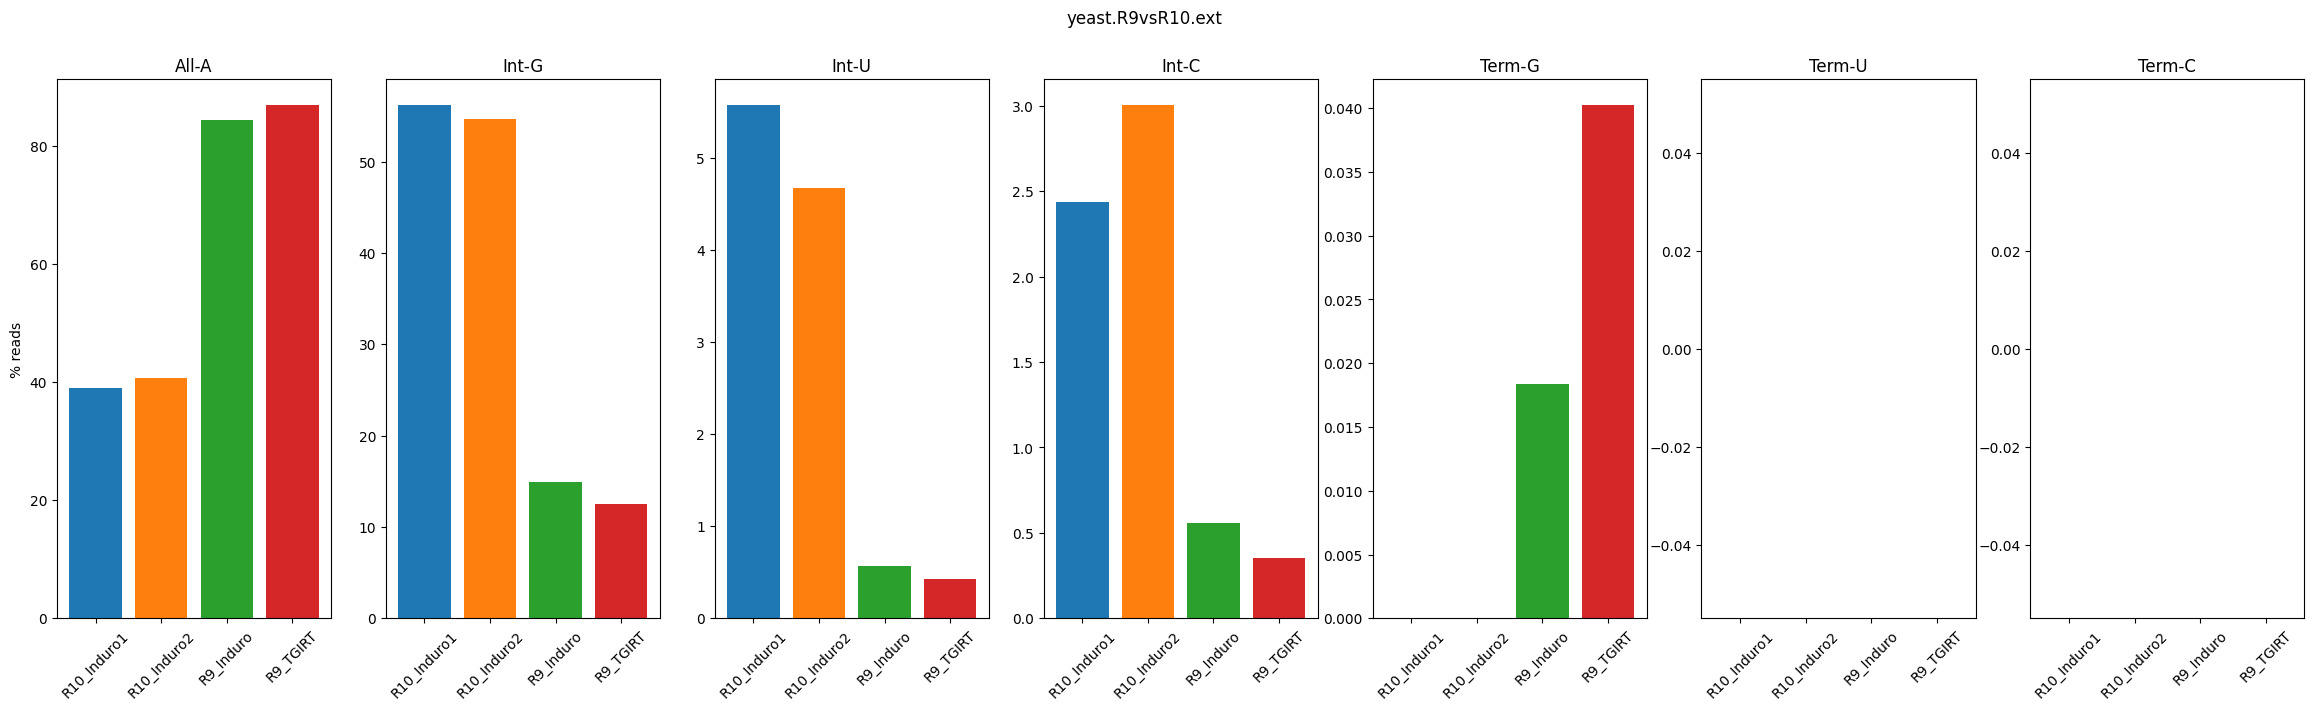

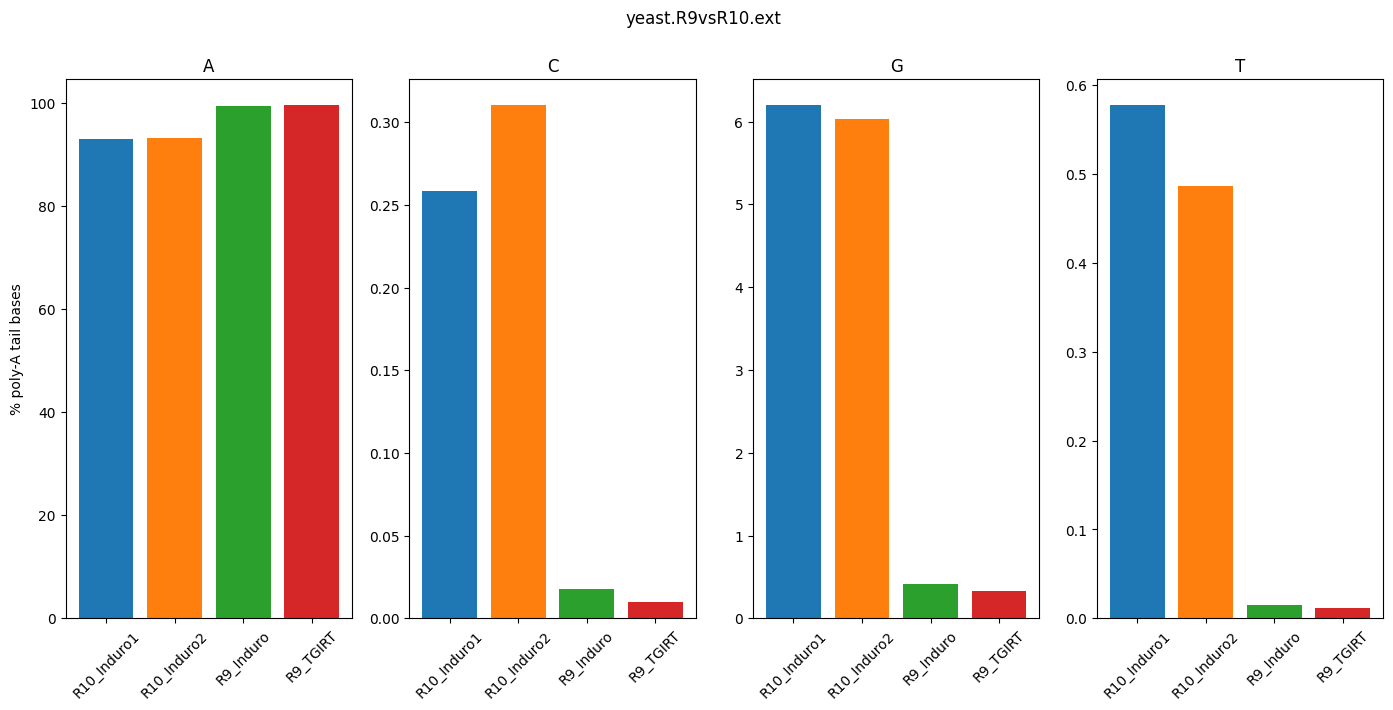

In [33]:
fnpat = "/no_backup/enovoa/users/lpryszcz/cluster/rna_mods/N3Pseq/get_pt.all/N3PS_R*_YeastSequin_*.bam.tsv"
sample2fname = {"_".join(os.path.basename(fn[:-8]).split("_")[1:]).replace("_YeastSequin", ""): fn for fn in sorted(glob(fnpat))}; sample2fname
bc2data, bc2count = get_data(sample2fname, feature="ext")
plot_data(bc2data, bc2count, "yeast.R9vsR10.ext", sample2fname.keys())